# Performing GPU Batch Prediction on Images with a PyTorch Model

In this example, we will introduce how to use the Ray AIR {class}`BatchPredictor <ray.train.batch_predictor.BatchPredictor>` for **large-scale batch inference with multiple GPU workers.**

For this demo, we will use the [Imagenette](https://github.com/fastai/imagenette) dataset, which is a subset of Imagenet with 10 classes.

First, we use {meth}`ray.data.read_images <ray.data.read_images>` to load the validation set from S3. Since the dataset is already structured with directory names as the labels, we can use the {class}`Partitioning <ray.data.datasource.Partitioning>` API to automatically extract image labels.

In [3]:
import ray
from ray.data.datasource.partitioning import Partitioning

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/val/"
partitioning = Partitioning("dir", field_names=["class"], base_dir=s3_uri)
ds = ray.data.read_images(s3_uri, partitioning=partitioning, mode="RGB")
ds


2023-02-14 18:45:47,930	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 10.0.49.247:6379...
2023-02-14 18:45:47,962	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
2023-02-14 18:45:48,239	INFO packaging.py:373 -- Pushing file package 'gcs://_ray_pkg_30175d6ead5ce825f5779cb63cdb5463.zip' (90.97MiB) to Ray cluster...
2023-02-14 18:45:49,908	INFO packaging.py:386 -- Successfully pushed file package 'gcs://_ray_pkg_30175d6ead5ce825f5779cb63cdb5463.zip'.


In [4]:
ds = ds.limit(1000)


Read progress: 100%|██████████| 50/50 [00:00<00:00, 3996.02it/s]


Notice that the label for images are their corresponding directory names (e.g. n01728920). To find the indices of our model output that correspond to these names, we'll need to download a mapping from the s3 bucket (`imagenet_class_index.json`). The actual class names can also be found from this file.

In [19]:
import boto3
import json

# Download mapping file from S3
s3 = boto3.resource("s3")
s3.meta.client.download_file(
    "air-example-data-2",
    "imagenette2/imagenet_class_index.json",
    "/tmp/imagenet_class_index.json",
)

# Build mappings
idx_to_class = json.load(open("/tmp/imagenet_class_index.json", "r"))
class_to_idx = {cls_name: int(index) for index, (cls_name, _) in idx_to_class.items()}
idx_to_class_name = {int(index): text for index, (_, text) in idx_to_class.items()}


Next, let's define a preprocessor to crop and normalize images, as well as convert the class names to indices with the map that we just constructed. We'll use a {class}`BatchMapper <ray.data.preprocessors.BatchMapper>` to implement this custom preprocessing logic. `BatchMapper` takes in a user defined function and applies that as the data transformation to the input dataset, before feeding it into the model.

In [7]:
import numpy as np
import pandas as pd
from torchvision import transforms
from ray.data.preprocessors import BatchMapper
from typing import Dict


def preprocess(batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    batch["image"] = np.array([transform(img).numpy() for img in batch["image"]])
    batch["label"] = np.array([class_to_idx[cls_name] for cls_name in batch["class"]])
    return batch


preprocessor = BatchMapper(fn=preprocess, batch_format="numpy")


## Build a BatchPredictor

Now that we have our dataset loaded and preprocessed with [Ray Data](datasets), we're ready to construct our {class}`BatchPredictor <ray.data.batch_predictor.BatchPredictor>`! A {class}`BatchPredictor <ray.data.batch_predictor.BatchPredictor>` takes a checkpoint and a predictor class (e.g., {class}`~ray.train.torch.TorchPredictor`, {class}`~ray.train.tensorflow.TensorflowPredictor`) and provides an interface to run batch prediction on Ray {class}`~ray.data.Dataset`s. It will distribute the inference workload across multiple workers when calling `predict()` and run prediction on multiple shards of data in parallel. You can find more details in [Using Predictors for Inference](air-predictors).

For the demo, we'll directly load a pretrained ResNet model from `torchvision.models` and construct a {class}`~ray.train.torch.TorchCheckpoint` which includes the preprocessor. You can also load your own Ray AIR checkpoint from your previous Train/Tune experiments. You can find more details about checkpoint loading at the [AIR `Checkpoint` API reference](air-checkpoint-ref).

In [ ]:
from torchvision import models
from ray.train.batch_predictor import BatchPredictor
from ray.train.torch import TorchCheckpoint, TorchPredictor

# Load the pretrained resnet model and construct a checkpoint
model = models.resnet152(pretrained=True)
checkpoint = TorchCheckpoint.from_model(model=model, preprocessor=preprocessor)

# Build a BatchPredictor from checkpoint
batch_predictor = BatchPredictor(checkpoint, TorchPredictor)


Finally, run batch prediction using {meth}`BatchPredictor.predict(...) <ray.train.batch_predictor.BatchPredictor.predict>`!

In [9]:
predictions = batch_predictor.predict(
    ds,
    feature_columns=["image"],
    keep_columns=["label"],
    batch_size=128,
    max_scoring_workers=3,
    num_gpus_per_worker=1,
)


2023-02-14 18:47:07,508	INFO batch_predictor.py:184 -- `num_gpus_per_worker` is set for `BatchPreditor`.Automatically enabling GPU prediction for this predictor. To disable set `use_gpu` to `False` in `BatchPredictor.predict`.
Map Progress (2 actors 1 pending): 100%|██████████| 9/9 [00:14<00:00,  1.62s/it]


We specified several parameters in `predict()`:
- `feature_columns` specifies which columns are required for the model. The selected columns will be concatenated to build a batch tensor.
- The columns in `keep_columns` will be returned together with the prediction results. For example, you can keep image labels for evaluation later.
- The BatchPredictor uses CPUs for inference by default, please specify `num_gpus_per_worker` if you want to use GPUs.

## Evaluating Prediction Accuracy

`BatchPredictor.predict()` will return a Ray Dataset with a column of model output with key `"predictions"`, and all columns specified in `keep_columns`.

In this example, the output of the ResNet model is a 1000-dimensional tensor containing the logits of each class. We'll measure accuracy with Top-1 and Top-5 accuracy.
(Top-N accuracy: The percentage of predictions where the true label falls in the top N predicted classes.)

In [22]:
def calculate_matches(batch: pd.DataFrame) -> pd.DataFrame:
    batch["top_5_pred"] = batch["predictions"].apply(lambda x: np.argsort(-x)[:5])
    batch["top_5_pred_name"] = batch["top_5_pred"].map(
        lambda x: [idx_to_class_name[idx] for idx in x]
    )
    batch["top_5_match"] = batch.apply(lambda x: x["label"] in x["top_5_pred"], axis=1)
    batch["top_1_match"] = batch.apply(
        lambda x: x["label"] == x["top_5_pred"][0], axis=1
    )
    return batch


predictions = predictions.map_batches(calculate_matches, batch_format="pandas")
print("Top-1 accuracy: ", predictions.mean(on="top_1_match"))
print("Top-5 accuracy: ", predictions.mean(on="top_5_match"))


Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 128.55it/s]


Top-1 accuracy:  0.849


Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 126.10it/s]


Top-5 accuracy:  0.99


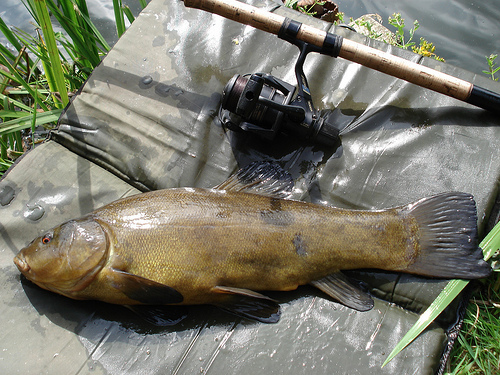

Top-1 Matched:  True
Top-5 Predictions:  ['tench', 'coho', 'reel', 'barracouta', 'gar']


In [31]:
from IPython.display import display
from PIL import Image

# Take an example from the model's prediction
sample_image = ds.take(1)[0]
sample_pred = predictions.take(1)[0]
display(Image.fromarray(sample_image["image"]))
print("Top-1 Matched: ", sample_pred["top_1_match"])
print("Top-5 Predictions: ", sample_pred["top_5_pred_name"])


## Save Prediction Results

There are a few options for saving your prediction results:
- You can call `ds.repartition(n)` to split your prediction results into n partitions, then n files will be created with `write_csv()` later.
- You can either store files to your local disk or S3 bucket by passing local path or S3 uri to `write_csv()`.
- Other output file formats are described here: [Ray Data Input/Output](https://docs.ray.io/en/latest/data/api/input_output.html)


In [ ]:
predictions.repartition(1).write_csv("/tmp/single_csv")
# >>> /tmp/single_csv/d757569dfb2845589b0ccbcb263e8cc3_000000.csv

predictions.repartition(3).write_csv("/tmp/multiple_csv")
# >>> /tmp/multiple_csv/2b529dc5d8eb45e5ad03e69fb7ad8bc0_000000.csv
# >>> /tmp/multiple_csv/2b529dc5d8eb45e5ad03e69fb7ad8bc0_000001.csv
# >>> /tmp/multiple_csv/2b529dc5d8eb45e5ad03e69fb7ad8bc0_000002.csv

# You can also save results to S3 by replacing local path to S3 URI
# predictions.write_csv(YOUR_S3_BUCKET_URI)
